Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

**IMPORTANT: DO NOT COPY OR SPLIT CELLS.** If you do, you'll mess the autograder. If need more cells to work or test things out, create a new cell. You may add as many new cells as you need.

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and group below:

In [1]:
COURSE = "Unsupervised Learning 2021"
GROUP = "D8A"
NAME = "Cano Morales Jeorval Jose" # Match your GitHub Classroom ID

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from numba import jit, njit
import warnings
warnings.filterwarnings("ignore")

# Density based clustering

In this assignment we will implement the DBSCAN algortuhm and compare it with the official Python implementation on HDBSCAN. We'll test our algorithms with the synthetic data from the HDBSCAN python implementation. This data set has 6 natural non-isotropic clusters of different densities, plus noise.

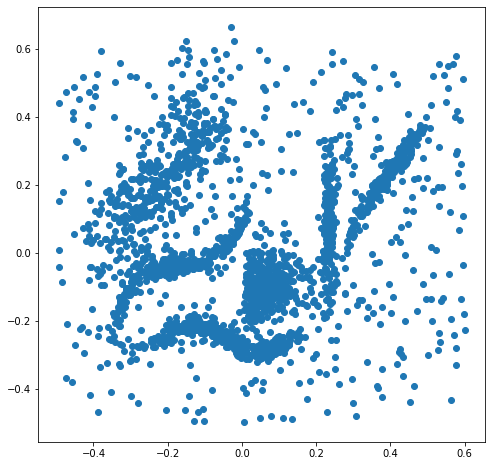

In [3]:
X = np.load('clusterable_data.npy')
figure = plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1]);

## DBSCAN, neighborhood function (4 points) 

In [4]:
@njit
def EuclideanDistance(Xrow1, Xrow2):       
        """
        Function to compute the Euclidean Distance
        
        Input:
        Xrow1, Xrow1: lists containing the values to compute the distance
        
        Output:
        return the Euclidean distance 
        """
        Distance = np.sqrt(np.sum(np.square(Xrow1 - Xrow2)))
        
        return Distance

# To find wether a point is a core point or not, we need to find its neighborhood.
# Implement such function below.
@njit
def eps_neighborhood(i, X, e):
    """ Returns indices of all points whose distance to X[i] is less than e."""
    
    # YOUR CODE HERE
    n_list = []
    
    for idx, val in enumerate(X):
        
        #case where is the same row 
        if idx == i:
            continue 
            
        temp = EuclideanDistance(X[i], val)
        #comparing if its within the neighborhood
        if temp <= e:
            n_list.append(idx)
    
    return n_list

Compare the results with the plots in the lecture notes.

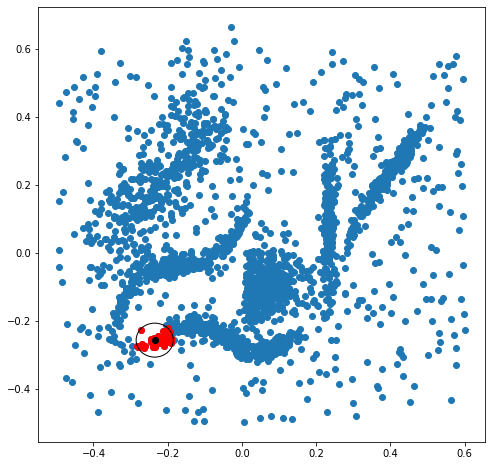

In [5]:
x_idx = 100
e=0.05
nn = eps_neighborhood(x_idx, X, e)
figure = plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[nn][:,0], X[nn][:,1], c='r')
plt.scatter(X[x_idx][0], X[x_idx][1], c='k')
circle = plt.Circle((X[x_idx][0], X[x_idx][1]),radius=e, fill=False)
ax=plt.gca()
ax.add_patch(circle)

## DBSCAN, grow cluster function (4 points) 

In [6]:
# We now need a function to grow a cluster.
# Implement a function that starts at a core point and finds all density reachable points from it, 
# and adds them to the cluster.
@jit
def grow_cluster(i, X, e, q, labels, m):
    """ Starts at core point X[i] and finds all density connected points to it.
        INPUTS:
            i: index of seed point
            X: data matrix
            e: neighbor radius
            q: min points in neighborhood to be considered core point
            labels: list of cluster labels
            m: current cluster label
        OUTPUTS:
            number of points in new cluster
            
        To implement this function try to build up a FIFO queu. Start your queue 
        with the initial neighbors, then test each neighbor to know wether is a core point or not.
        If the neighbor is a core point add its neighbors to the queue, else do nothing as it is a boundary point.
        
        The queu will grow with each new core point's neighbors, until all density connected points are tested.
    """
    
    # Append i to cluster
    labels[i] = m
    
    # Create a FIFO list to queu potential new core points to test.
    queu = list(eps_neighborhood(i, X, e))
        
    #list to save the core points already used, so we do not repeat them
    core_points = [i]
    # For each point in queu, search its neighborhood, and new core points to queu.
    j = 0
    while j < len(queu):
        
        # YOUR CODE HERE
        idx = queu[j]
        
        #getting the neighborhood
        neighbors = eps_neighborhood(idx , X, e)
        
        #checking whether is a core point or not, and if it is, it's necessary to check whether is a core point already used
        if len(neighbors) >= q and idx not in core_points:
            
            #adding new values to the queue
            queu.extend(neighbors)
            
            #saving the new core points
            core_points.append(idx)
            
            #the neighborhood of the core point gets into the cluster of the latter.
            labels[neighbors] = m
        
        j += 1
    
    # return size of cluster, just to return a value
    return len(queu)

Again, compare the results with the plots on the lecture notes.

Cluster size obtained: 8993, should be 8993


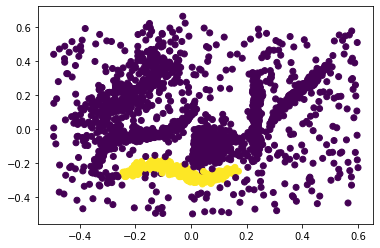

In [7]:
labels = np.zeros(len(X))
size = grow_cluster(100, X, 0.02, 5, labels, 1)
plt.scatter(X[:,0], X[:,1], c=labels)
print(f'Cluster size obtained: {size}, should be {8993}')

## Combining both function into the DBSCAN algorithm

We reproduce the same function provided in the notes for convinience. Refer to the notes for a discussion of the algorithm.

In [8]:
@jit
def dbscan(X, e, q):
    """ The DBSCAN algorithm. Unoptimized implementation with pedagogical purposes.
        
        INPUTS:
                -X: data matrix
                -e: epsilon, the neighbor radius arround each point
                -q: The minimum number of points for a cluster to be dense
    """
    
    n, d = X.shape
    # Array to hold cluster assignments: 0 is not considered, -1 is noise
    # You need to return this array correctly
    labels = np.zeros(n)
    
    # Current cluster label
    m = 0
    
    # Instead of using sets, well just iterate over every point in order.
    # If you want to choose at random, you can shuffle X before starting.
    # I don't beleive it makes a difference
    for i, x in enumerate(X):
        if labels[i] != 0:
            # Point already in another cluster
            continue
        nbrs = eps_neighborhood(i, X, e)
        if len(nbrs) < q:
            # Is a noise point (so far, can be claimed later.)
            labels[i] = -1
            continue
        # else, x is a core point
        m += 1
        m_size = grow_cluster(i, X, e, q, labels, m)
        
    return labels

Compare results with lecture notes.

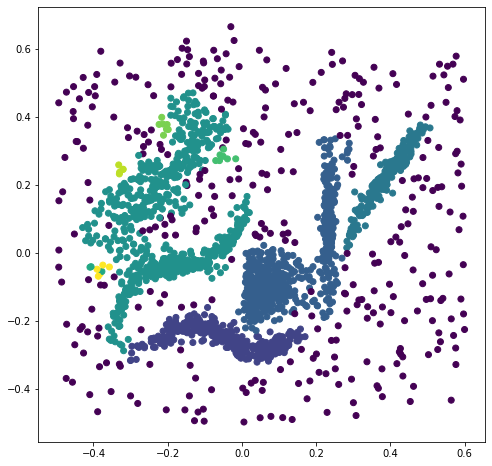

In [9]:
# Now test different values of e and q.
# A good choice seems to be e = 0.025 and q = 4.
labels = dbscan(X, 0.025, 4)
figure = plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=labels)
plt.show()

In [10]:
np.unique(labels)

array([-1.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

## HDBSCAN (2 points)

Watch video, read documentation. Then try HDBSCAN with the same sample dataset. Compare.

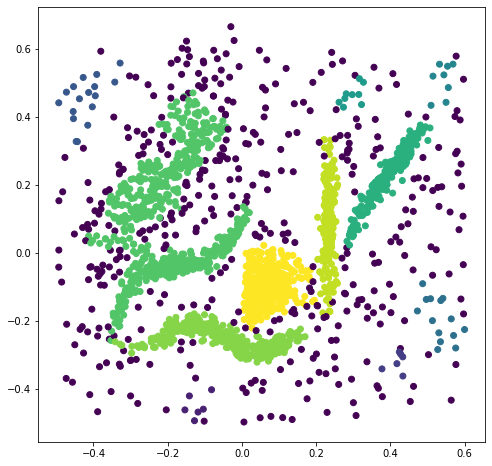

In [11]:
# Write your code here, add cells if needed.
import hdbscan

# YOUR CODE HERE

"""
I chose as min_sample(q) equal to 5 since in the algorith made by I do not take into consideration itself in the number of nodes 
in the nighborhood, for example, after applying eps_neighborhood I get 4 neighbors we only compare the number 4 against q, however, in 
the hdbscan the node itself is consider, taking the prior example if we get 4 neighbors we add 1 for the node itself, therefore; as 
in dbscan we used 4 we need to use 5 to have a beter comparison
"""
model = hdbscan.HDBSCAN(min_samples = 5, cluster_selection_epsilon = 0.025, metric = 'euclidean')

labels_ = model.fit_predict(X)
figure = plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=labels_)
plt.show()

In [12]:
np.unique(labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In hdbscan exist 2 cluster more than in dbscan, and also are clusters in places where dbscan consider them as noise, but hdbscan not, for example in the right and left upper corner and also in the right lower cornes